In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
import warnings
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')
import gc
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output
seed = 2019

/kaggle/input/wns-analyticswizard/test_aq1fgdb/test.csv
/kaggle/input/wns-analyticswizard/train_na17sgz/view_log.csv
/kaggle/input/wns-analyticswizard/train_na17sgz/item_data.csv
/kaggle/input/wns-analyticswizard/train_na17sgz/train.csv
/kaggle/input/wns-analyticswizard/sample_submission_ipsblct/sample_submission.csv
/kaggle/input/wns-analytics-wizard-making-train-test/__output__.json
/kaggle/input/wns-analytics-wizard-making-train-test/__notebook__.ipynb
/kaggle/input/wns-analytics-wizard-making-train-test/wns_train.csv
/kaggle/input/wns-analytics-wizard-making-train-test/__results__.html
/kaggle/input/wns-analytics-wizard-making-train-test/custom.css
/kaggle/input/wns-analytics-wizard-making-train-test/wns_test.csv


In [2]:
train = pd.read_csv('/kaggle/input/wns-analytics-wizard-making-train-test/wns_train.csv', parse_dates = ['impression_time'])
view_log = pd.read_csv('../input/wns-analyticswizard/train_na17sgz/view_log.csv', parse_dates = ['server_time'])
item_data = pd.read_csv('../input/wns-analyticswizard/train_na17sgz/item_data.csv')
test = pd.read_csv('/kaggle/input/wns-analytics-wizard-making-train-test/wns_test.csv', parse_dates = ['impression_time'])

In [3]:
view_log.head()

,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855
3,2018-10-15 08:58:00,android,121691,2430,12774
4,2018-10-15 08:58:00,android,218564,19227,28296


In [4]:
view_log['device_type'].value_counts()

android    3117737
iphone         861
web             24
Name: device_type, dtype: int64

In [5]:
android = view_log[view_log['device_type']=='android']['user_id'].to_list()
iphone = view_log[view_log['device_type']=='iphone']['user_id'].to_list()
web = view_log[view_log['device_type']=='web']['user_id'].to_list()

In [6]:
set(android).intersection(set(web))

{19413,
 24863,
 25143,
 26836,
 27143,
 34770,
 37434,
 39151,
 39469,
 42740,
 49910,
 55638,
 67074,
 67674,
 69682,
 71384,
 75774,
 80003,
 81953,
 82970,
 87841,
 88355,
 91568,
 91629}

In [7]:
# train = train.sort_values(by='impression_time')
# view_log = view_log.sort_values(by='server_time')
# test = test.sort_values(by='impression_time')

In [8]:
train.head()

,app_code,date,hour,impression_id,impression_time,is_4G,is_click,minute,month,os_version,user_id,ad_iter,ad_delta,item_id,time_elapsed,total_visits
0,422,15,0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,0,0.0,0,11,old,87862,1.0,NaN,43886.0,37789.0,1.0
1,467,15,0,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,1,1.0,1,11,latest,63410,1.0,NaN,43209.0,29938.0,5.0
2,259,15,0,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,1,0.0,2,11,intermediate,71748,1.0,NaN,122348.0,32343.0,1.0
3,244,15,0,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,1,0.0,2,11,latest,69209,1.0,NaN,104035.0,301.0,1.0
4,473,15,0,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,0,0.0,2,11,latest,62873,1.0,NaN,4069.0,140.0,1.0


In [9]:
train['month'] = train['impression_time'].dt.month
train['date'] = train['impression_time'].dt.day
train['hour'] = train['impression_time'].dt.hour
train['minute'] = train['impression_time'].dt.minute
train['week_day'] = train['impression_time'].dt.weekday
train['is_weekend'] = train['week_day'].apply(lambda x: 1 if x in [5,6] else 0)

test['month'] = test['impression_time'].dt.month
test['date'] = test['impression_time'].dt.day
test['hour'] = test['impression_time'].dt.hour
test['minute'] = test['impression_time'].dt.minute
test['week_day'] = test['impression_time'].dt.weekday
test['is_weekend'] = test['week_day'].apply(lambda x: 1 if x in [5,6] else 0)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237609 entries, 0 to 237608
Data columns (total 18 columns):
app_code           237609 non-null int64
date               237609 non-null int64
hour               237609 non-null int64
impression_id      237609 non-null object
impression_time    237609 non-null datetime64[ns]
is_4G              237609 non-null int64
is_click           237609 non-null float64
minute             237609 non-null int64
month              237609 non-null int64
os_version         237609 non-null object
user_id            237609 non-null int64
ad_iter            237609 non-null float64
ad_delta           162886 non-null float64
item_id            235988 non-null float64
time_elapsed       235988 non-null float64
total_visits       235988 non-null float64
week_day           237609 non-null int64
is_weekend         237609 non-null int64
dtypes: datetime64[ns](1), float64(6), int64(9), object(2)
memory usage: 32.6+ MB


In [11]:
train = pd.merge(train, item_data, how='left', on='item_id')
test = pd.merge(test, item_data, how='left', on='item_id')

In [12]:
valid = set(list(train.columns)).difference(['is_click','impression_id','impression_time','ad_delta','time_elapsed'])

for col in valid:
    df = pd.concat([train[col],test[col]], axis=0, ignore_index=0)
    mapping = df.value_counts().to_dict()
    train[col + '_count'] = train[col].map(mapping)
    test[col + '_count'] = test[col].map(mapping)

In [13]:
train.shape

(237609, 41)

In [14]:
valid = ['app_code','item_id','item_price','product_type','category_1','category_2','category_3']

columns = ['date','hour','week_day','is_weekend','minute','month','os_version','is_4G']

for col1 in valid:
    for col2 in columns:
        train[col1 + '_' + col2 + '_mean'] = train[col1]/train.groupby(col2)[col1].transform('mean')
        test[col1 + '_' + col2 + '_mean'] = test[col1]/train.groupby(col2)[col1].transform('mean')

for col1 in valid:
    valid2 = set(valid).difference([col1])
    for col2 in valid2:
        train[col1 + '_' + col2 + '_mean'] = train[col1]/train.groupby(col2)[col1].transform('mean')
        test[col1 + '_' + col2 + '_mean'] = test[col1]/train.groupby(col2)[col1].transform('mean')

In [15]:
train.shape , test.shape

((237609, 139), (90675, 138))

In [16]:
train = train.fillna(-999)
test = test.fillna(-999)

In [17]:
# X = pd.get_dummies(train['os_version'])
# train = train.drop('os_version',1)
# train = pd.concat([train, X], axis=1)

# X = pd.get_dummies(test['os_version'])
# test = test.drop('os_version',1)
# test = pd.concat([test, X], axis=1)


# X = pd.get_dummies(train['is_4G'])
# train = train.drop('is_4G',1)
# train = pd.concat([train, X], axis=1)

# X = pd.get_dummies(test['is_4G'])
# test = test.drop('is_4G',1)
# test = pd.concat([test, X], axis=1)

In [18]:
mapping = {'old':0, 'intermediate':1, 'latest':2}

train['os_version'] = train['os_version'].map(mapping)
test['os_version'] = test['os_version'].map(mapping)

In [19]:
target = train['is_click']
train = train.drop(['impression_id','impression_time','is_click','ad_iter'],1)

test = test.drop(['impression_id','impression_time','ad_iter'], 1)

In [20]:
# def group_noise(col):
#     valid = train[col].value_counts()
#     valid = valid[valid>10].index
    
#     train[col] = np.where(train[col].isin(valid),train[col],np.nan)
#     test[col] = np.where(test[col].isin(valid),test[col],np.nan)
    
#     return train[col], test[col]

In [21]:
# train['ad_iter'], test['ad_iter'] = group_noise('ad_iter')

In [22]:
n_folds = 5
skfold = StratifiedKFold(n_splits = n_folds, random_state = seed)
kfold = KFold(n_splits = n_folds, random_state = seed)

oof = np.zeros(len(train))
pred = np.zeros(len(test))
scores=[]
feat_imp = pd.DataFrame()
feat_imp['features'] = train.columns
feat_imp['importance'] = 0

In [23]:


# for fold_n, (train_index, valid_index) in enumerate(kfold.split(train, target)):
    
#     print('Fold ',fold_n + 1)
    
#     xgbclf = XGBClassifier(
#         n_estimators=1000,
#         max_depth=3,
#         learning_rate=0.1,
#         subsample=1,
#         colsample_bytree=1,
#         random_state = seed
# #         tree_method='gpu_hist'  # THE MAGICAL PARAMETER
#     )
    
#     X_train_, X_valid = train.iloc[train_index], train.iloc[valid_index]
#     y_train_, y_valid = target.iloc[train_index], target.iloc[valid_index]
#     xgbclf.fit(X_train_,y_train_, early_stopping_rounds = 50, eval_set=[(X_train_,y_train_),(X_valid, y_valid)], eval_metric = 'auc', verbose = 50)
#     del X_train_,y_train_
#     pred += xgbclf.predict_proba(test)[:,1]/n_folds
#     val=xgbclf.predict_proba(X_valid)[:,1]
#     oof[valid_index] = val
#     scores.append(roc_auc_score(y_valid, val))
#     feat_imp['importance'] += xgbclf.feature_importances_/n_folds
#     del xgbclf, X_valid
#     print('ROC accuracy: {}'.format(roc_auc_score(y_valid, val)))
#     del val,y_valid
#     gc.collect()

# print('Mean CV ', np.mean(scores))

In [24]:
xgbclf = XGBClassifier(
        n_estimators=1000,
        max_depth=3,
        learning_rate=0.1,
        subsample=1,
        colsample_bytree=1,
        random_state = seed,
        tree_method='gpu_hist' 
    )

rfe = RFECV(estimator=xgbclf, step=1, cv=KFold(n_splits=5, random_state = seed), scoring='roc_auc', verbose=2)

In [25]:
rfe.fit(train, target)

Fitting estimator with 135 features.
Fitting estimator with 134 features.
Fitting estimator with 133 features.
Fitting estimator with 132 features.
Fitting estimator with 131 features.
Fitting estimator with 130 features.
Fitting estimator with 129 features.
Fitting estimator with 128 features.
Fitting estimator with 127 features.
Fitting estimator with 126 features.
Fitting estimator with 125 features.
Fitting estimator with 124 features.
Fitting estimator with 123 features.
Fitting estimator with 122 features.
Fitting estimator with 121 features.
Fitting estimator with 120 features.
Fitting estimator with 119 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
F

RFECV(cv=KFold(n_splits=5, random_state=2019, shuffle=False),
      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=1000, n_jobs=1,
                              nthread=None, objective='binary:logistic',
                              random_state=2019, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, seed=None, silent=None,
                              subsample=1, tree_method='gpu_hist',
                              verbosity=1),
      min_features_to_select=1, n_jobs=None, scoring='roc_auc', step=1,
      verbose=2)

In [26]:
print('Optimal number of features:', rfe.n_features_)

Optimal number of features: 16


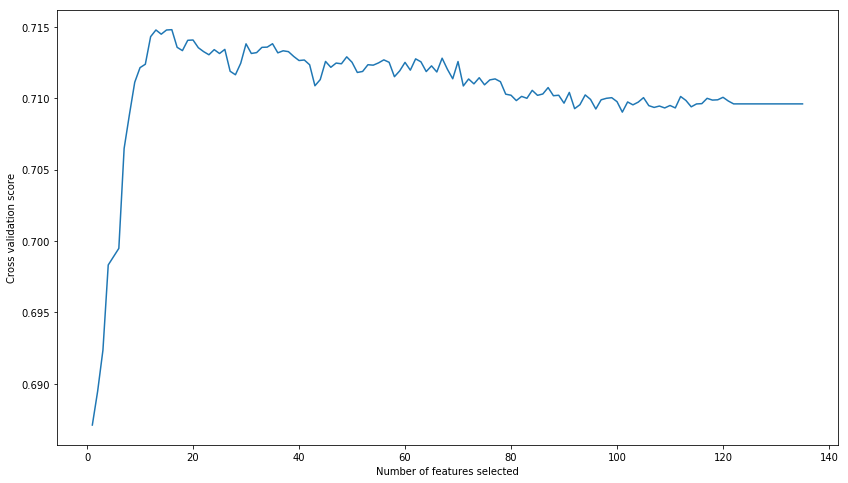

In [27]:
plt.figure(figsize=(14, 8))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

In [28]:
# sub = pd.read_csv('../input/wns-analyticswizard/sample_submission_ipsblct/sample_submission.csv')
# sub['is_click'] = pd.Series(pred)
# sub.to_csv('sixth_sub.csv', index=False)

In [29]:
# feat_imp.to_csv('Feat_imp_sub6.csv',index=False)

In [30]:
# df=feat_imp.sort_values(by='importance', ascending=False)
# plt.figure(figsize=(10,10))
# sns.barplot(data= df, x=df['importance'], y=df['features'])
# plt.title('Feature Importances')

In [31]:
for col in train.columns[rfe.ranking_ == 1]:
    print(col)

app_code
os_version
time_elapsed
user_id_count
item_id_count
app_code_count
app_code_date_mean
app_code_week_day_mean
app_code_is_weekend_mean
app_code_minute_mean
app_code_month_mean
app_code_os_version_mean
app_code_is_4G_mean
app_code_product_type_mean
app_code_category_1_mean
app_code_category_2_mean


In [32]:
useful_columns=pd.Series(X.columns[rfe.ranking_ == 1])
useful_columns.to_csv('useful_features.csv',index=False)

NameError: name 'X' is not defined